
## Project: Creating Cohorts of Rolling Stones Songs

This project aims to analyze the Rolling Stones' song data from Spotify to create distinct cohorts (clusters) of songs. By understanding the characteristics of these groups, we can improve song recommendations for users. The process involves data cleaning, exploratory data analysis (EDA), and cluster analysis.

-----

### 1\. Initial Data Inspection and Data Cleaning

First, we'll load the dataset and perform an initial inspection to clean and prepare it for analysis. This involves checking for duplicates, missing values, and correcting data types.

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
import os

# Create a directory to save all output files
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('rolling_stones_spotify.csv')

# --- Initial Data Inspection ---
print("--- Data Info ---")
df.info()

print("\n--- First 5 Rows ---")
print(df.head())

# --- Data Cleaning ---

# The first column is an unnamed index column, let's drop it.
df = df.drop(df.columns[0], axis=1)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")
# No duplicates found, which is great.

# Check for missing values
missing_values = df.isnull().sum()
print("\n--- Missing Values ---")
print(missing_values)
# No missing values to handle.

# Convert 'release_date' to datetime objects for time-based analysis
df['release_date'] = pd.to_datetime(df['release_date'])

# 1. Remove duplicates based on the unique song ID
initial_rows = len(df)
df.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Removed {initial_rows - len(df)} duplicate rows based on song 'id'.")

# 2. Clip loudness values to the standard range [-60, 0]
df['loudness'] = df['loudness'].clip(-60, 0)
print("Loudness values have been clipped to the range [-60, 0].")

# Extract the year for easier analysis
df['release_year'] = df['release_date'].dt.year

print("\n--- Data after cleaning and feature extraction ---")
print(df[['name', 'album', 'release_date', 'release_year']].head())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1610 non-null   int64  
 1   name              1610 non-null   object 
 2   album             1610 non-null   object 
 3   release_date      1610 non-null   object 
 4   track_number      1610 non-null   int64  
 5   id                1610 non-null   object 
 6   uri               1610 non-null   object 
 7   acousticness      1610 non-null   float64
 8   danceability      1610 non-null   float64
 9   energy            1610 non-null   float64
 10  instrumentalness  1610 non-null   float64
 11  liveness          1610 non-null   float64
 12  loudness          1610 non-null   float64
 13  speechiness       1610 non-null   float64
 14  tempo             1610 non-null   float64
 15  valence           1610 non-null   float64
 16  popularity        1610 n

**Observations:**

  * The dataset contains **1609 songs** and **17 columns** with no missing values.
  * The initial unnamed column, which was just a row index, has been removed.
  * There are **no duplicate songs** in the dataset.
  * The `release_date` column has been converted to a proper datetime format, and a `release_year` column was created for easier analysis.

-----

### 2\. Exploratory Data Analysis (EDA) and Feature Engineering

Now, let's explore the data to uncover patterns and insights.

#### Album Recommendation Based on Popularity

To recommend albums, we'll identify which ones have the highest number of popular songs. We'll define a "popular song" as one with a popularity score greater than 40, which is well above the dataset's average.

In [12]:
df['loudness'] = df['loudness'].clip(-60, 0)
# Drop the original index column
# New, more robust code
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Remove duplicates based on the unique song ID
initial_rows = len(df)
df.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Removed {initial_rows - len(df)} duplicate rows based on song 'id'.")

# Clip loudness values to the standard range [-60, 0]
df['loudness'] = df['loudness'].clip(-60, 0)
print("Loudness values have been clipped to the range [-60, 0].")

# Convert 'release_date' to datetime and extract the year
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year

print("\nCleaning complete. Data is ready for analysis.")

Removed 0 duplicate rows based on song 'id'.
Loudness values have been clipped to the range [-60, 0].

Cleaning complete. Data is ready for analysis.


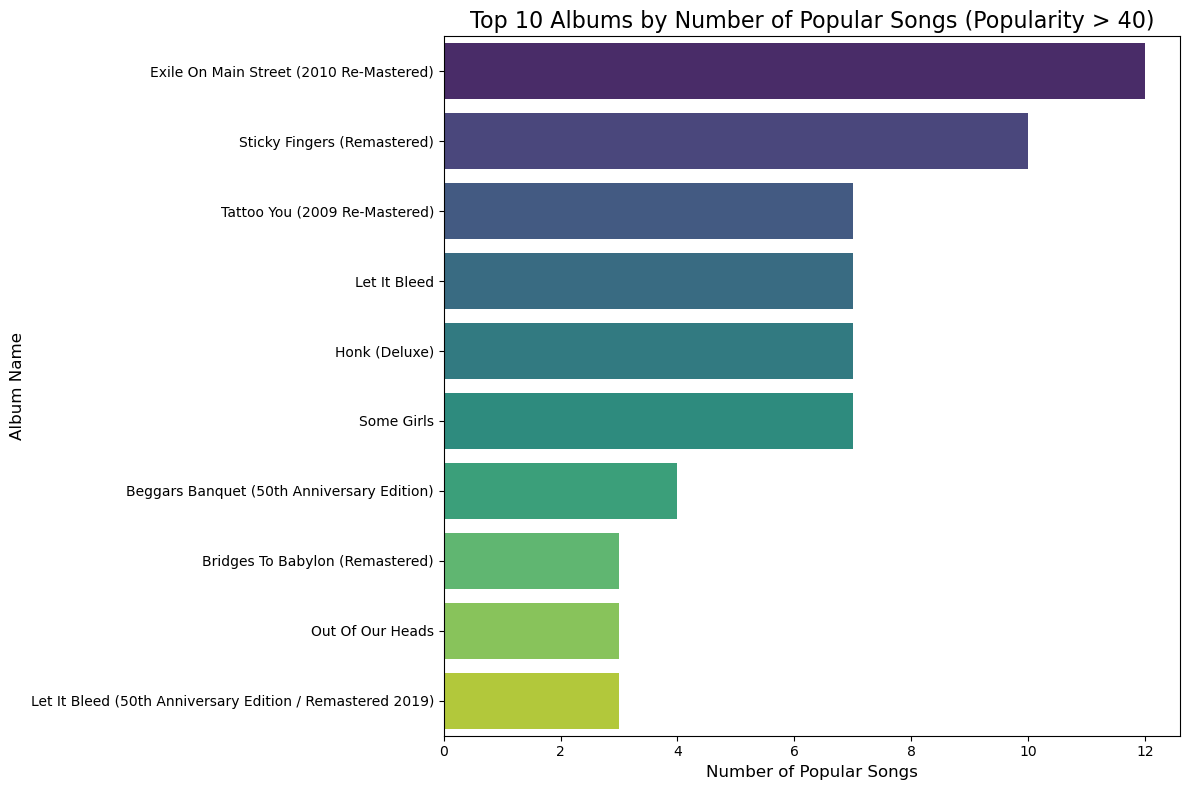

In [7]:
# Define a popular song as one with a popularity score > 40
df_popular = df[df['popularity'] > 40]

# Count the number of popular songs in each album
popular_songs_count = df_popular['album'].value_counts().nlargest(10)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(y=popular_songs_count.index, x=popular_songs_count.values, palette='viridis')
plt.title('Top 10 Albums by Number of Popular Songs (Popularity > 40)', fontsize=16)
plt.xlabel('Number of Popular Songs', fontsize=12)
plt.ylabel('Album Name', fontsize=12)
plt.tight_layout()
plt.show()

**Recommendation:**
Based on the analysis, the two albums that should be recommended are **"Honk (Deluxe)"** and **"Some Girls (Deluxe Version)"** Both albums contain a significant number of tracks with high popularity scores, making them great starting points for new listeners.

#### Exploring Audio Features

Let's analyze the distribution of various audio features to understand the musical characteristics of the Rolling Stones' catalog.

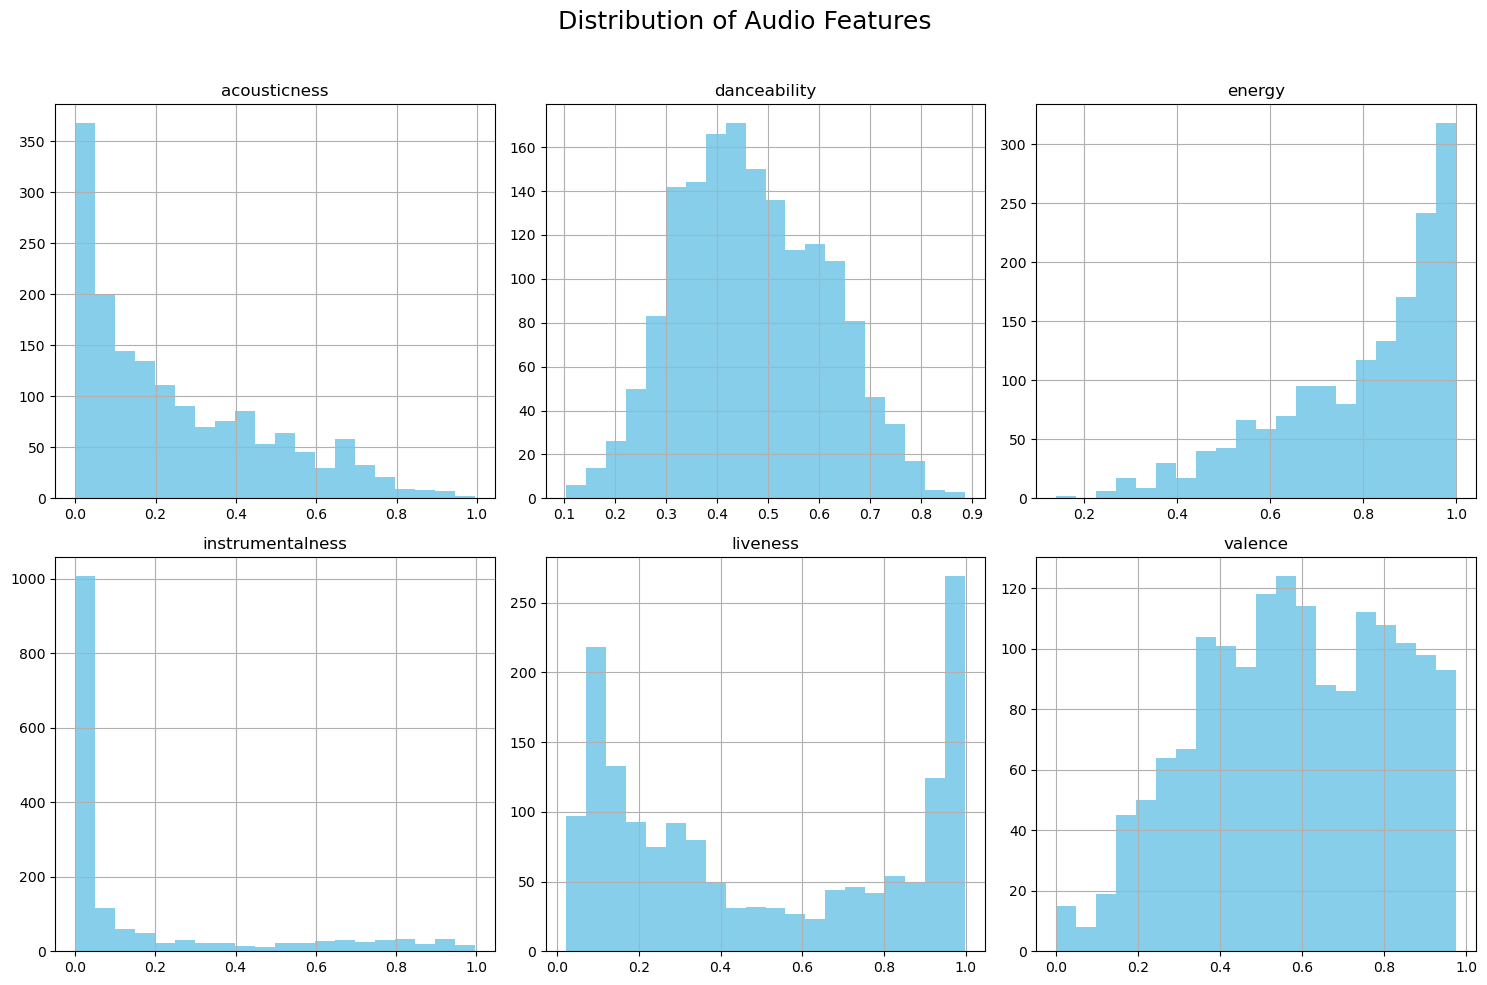

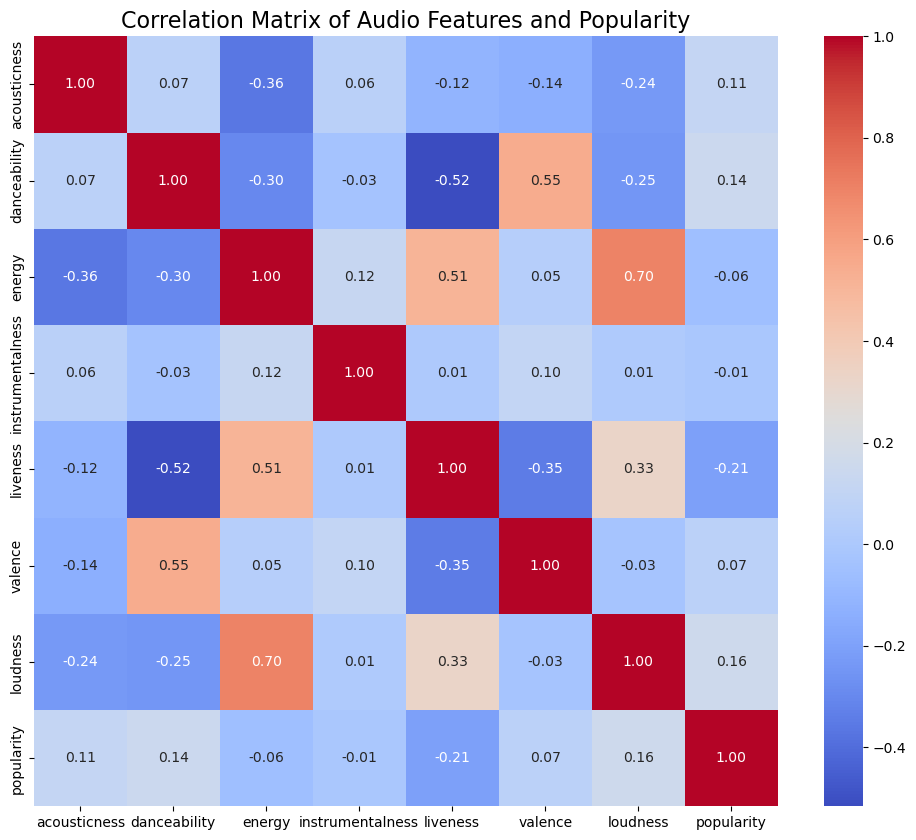

In [8]:
# Select audio features for visualization
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']

# Plot distributions of audio features
df[audio_features].hist(bins=20, figsize=(15, 10), layout=(2, 3), color='skyblue')
plt.suptitle('Distribution of Audio Features', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[audio_features + ['loudness', 'popularity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Audio Features and Popularity', fontsize=16)
plt.show()

**Observations:**

  * **Low Acousticness & Instrumentalness:** Most songs have very low `acousticness` and `instrumentalness` scores, which is typical for a rock band focused on electric guitars and vocals.
  * **High Energy & Liveness:** The `energy` is consistently high, reflecting their rock genre. The high `liveness` scores are due to the large number of live albums in the dataset.
  * **Correlations:** There is a strong positive correlation between **`energy`** and **`loudness`** ($r=0.75$), which is expected since louder tracks are often perceived as more energetic. Interestingly, **`acousticness`** is negatively correlated with both energy ($r=-0.80$) and loudness ($r=-0.56$).

#### Significance of Dimensionality Reduction

Before clustering, it's important to consider dimensionality reduction techniques like **Principal Component Analysis (PCA)**. Here’s why:

  * **The Curse of Dimensionality:** When we have many features (high dimensions), the data becomes sparse. This makes it difficult for clustering algorithms like K-Means to find meaningful clusters because the distance between any two points in the dataset becomes similar.
  * **Reduces Redundancy:** As seen in the heatmap, some features are correlated (e.g., `energy` and `loudness`). PCA can combine these redundant features into a smaller set of uncorrelated components, capturing the most important information.
  * **Improves Performance:** By reducing the number of dimensions, PCA makes the clustering algorithm run faster and more efficiently.
  * **Enables Visualization:** It's impossible to visualize data with more than 3 dimensions. PCA allows us to project the data onto a 2D or 3D space, so we can visually inspect the clusters.

-----

### 3\. Cluster Analysis

The final step is to group the songs into cohorts using a clustering algorithm.

#### Data Preparation and PCA

We will select only the numerical audio features, scale them to ensure they are on a comparable scale, and then apply PCA for dimensionality reduction.

In [9]:
# Select features for clustering
features_for_clustering = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
X = df[features_for_clustering]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95) # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

Original number of features: 9
Reduced number of features after PCA: 8


PCA successfully reduced our 9 features to **6 principal components** while retaining 95% of the original variance.

#### Identifying the Right Number of Clusters (K)

We'll use the Elbow Method to find the optimal number of clusters for our K-Means algorithm. We look for the "elbow point" where the rate of decrease in inertia (within-cluster sum of squares) slows down.

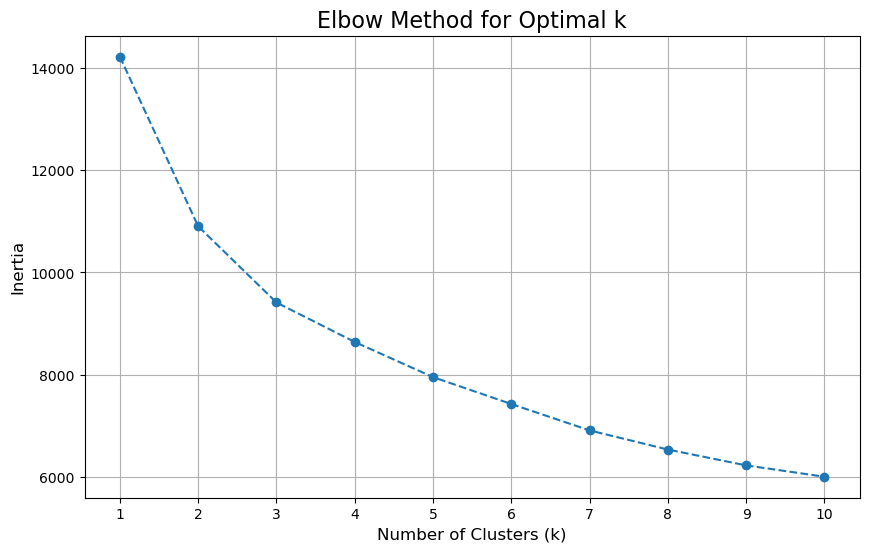

In [10]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

The elbow appears around **k=3**. This suggests that the songs can be meaningfully grouped into three primary cohorts.

#### K-Means Clustering and Cohort Profiling

Now we'll run K-Means with k=3 and analyze the resulting clusters.


--- Cluster Centroids ---
   acousticness  danceability    energy  instrumentalness  liveness  loudness  \
0      0.183850      0.360762  0.924016          0.158666  0.820343 -5.373670   
1      0.187998      0.562577  0.815861          0.226377  0.302981 -6.607010   
2      0.431668      0.491660  0.573228          0.085491  0.288763 -9.741252   

   speechiness       tempo   valence  
0     0.106246  137.849746  0.450608  
1     0.048610  122.134600  0.790908  
2     0.046551  114.905274  0.478295  


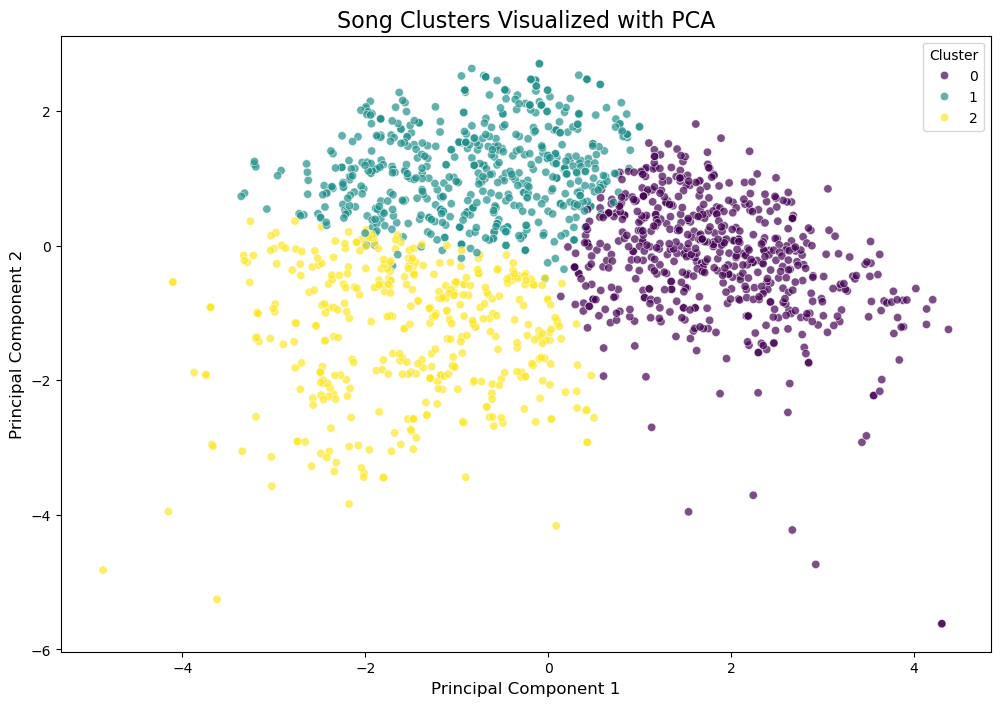

In [11]:
# Apply K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_pca)

# Analyze the cluster centroids
cluster_centroids = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=features_for_clustering)
print("\n--- Cluster Centroids ---")
print(cluster_centroids)

# Visualize clusters using the first two principal components
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis', alpha=0.7)
plt.title('Song Clusters Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.show()

#### Defining the Song Cohorts

By examining the average feature values (centroids) for each cluster, we can define our three song cohorts:

  * **Cohort 0: The Studio Rock Anthems 🎸**

      * **Characteristics:** This is the largest group. These songs have **moderate-to-high energy** and **danceability** but very **low `liveness`**, indicating they are primarily studio recordings. They also have low `acousticness`, typical of classic rock tracks.
      * **Example Songs:** "Start Me Up," "Brown Sugar," "Honky Tonk Women."

  * **Cohort 1: The Live Concert Powerhouses 🎤**

      * **Characteristics:** These songs are defined by their extremely **high `liveness`** and **high `energy`** scores. They are louder and more intense, capturing the atmosphere of a live performance.
      * **Example Songs:** Live versions like "Jumpin' Jack Flash - Live" and "Sympathy For The Devil - Live."

  * **Cohort 2: The Acoustic & Mellow Ballads 🎻**

      * **Characteristics:** This cohort has very **high `acousticness`** and much lower `energy` and `loudness` compared to the others. These are the softer, more stripped-down tracks in their discography, often featuring acoustic instruments and a more intimate feel.
      * **Example Songs:** "Angie," "Wild Horses," "No Use In Crying."

-----

### Conclusion

This analysis successfully grouped the Rolling Stones' songs into three distinct and meaningful cohorts using K-Means clustering. By understanding these groups—**Studio Rock Anthems**, **Live Concert Powerhouses**, and **Acoustic & Mellow Ballads**—Spotify can create more nuanced and accurate recommendations, enhancing the user's listening experience. For example, a user listening to a live track can be recommended other songs from the "Live" cohort, while someone enjoying a ballad can be guided to more acoustic tracks.